<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

This notebook looks at the age / sex differences within cohorts.

In [1]:
# This block is just for importing the necessary libraries.  
import os
import pickle
from collections import defaultdict

# Numerical libraries
import pandas as pd
import numpy as np
import numpy.ma as ma

import biom
import arviz as az
from scipy.spatial.distance import euclidean
from gneiss.balances import sparse_balance_basis

from statsmodels.discrete.conditional_models import ConditionalLogit
from patsy import dmatrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials)
from logit import conditional_logistic_regression, clogit_predict
from plot import (rankplot, networkplot, vectorplot)
import random
import warnings
warnings.simplefilter('ignore')

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp'
berding_directory = '../sfari/data/sra/Berding2020'

results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

pd.options.display.max_rows = 100 

In [2]:
# load biom tables
amp_biom = biom.load_table(f'{kang_directory}/age_sex_match_week0_ogu.biom')
wgs_biom = biom.load_table(f'{wgs_directory}/ogus_table.biom')
amp_table = amp_biom.to_dataframe().T
wgs_table = wgs_biom.to_dataframe().T

# load metadata tables
amp_md_orig = pd.read_table(f'{kang_directory}/combined_sample_metadata_0.txt', index_col=0)
wgs_md_orig = pd.read_table(f'{wgs_directory}/sample_metadata.txt', index_col=0)

<AxesSubplot:xlabel='Age', ylabel='Count'>

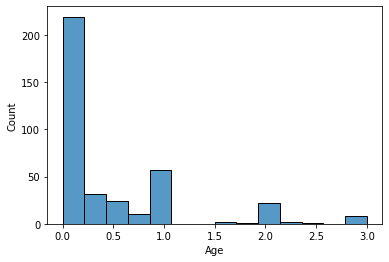

In [3]:
cols = ['Match_IDs', 'Age']
amp_md = amp_md_orig.sort_values(['Match_IDs', 'Age'])
age_diffs = amp_md[cols].groupby('Match_IDs').diff()['Age']
age_diffs = age_diffs.dropna()
sns.histplot(age_diffs)

<AxesSubplot:xlabel='Age', ylabel='Count'>

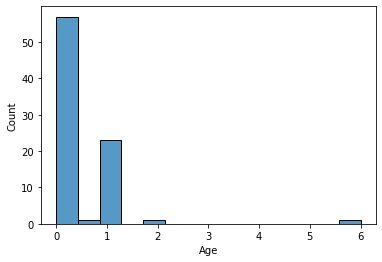

In [4]:
cols = ['Match_IDs', 'Age']
wgs_md = wgs_md_orig.sort_values(['Match_IDs', 'Age'])
age_diffs = wgs_md[cols].groupby('Match_IDs').diff()['Age']
age_diffs = age_diffs.dropna()
sns.histplot(age_diffs)

In [15]:
cols = ['Match_IDs', 'Sex']
amp_md = amp_md_orig.sort_values(['Match_IDs', 'Sex'])
f = lambda x: x.iloc[0]['Sex'] == x.iloc[1]['Sex']
sex_diffs = amp_md[cols].groupby('Match_IDs').apply(f)
sex_diffs.value_counts()

True     356
False     21
dtype: int64

In [14]:
cols = ['Match_IDs', 'Sex']
wgs_md = wgs_md_orig.sort_values(['Match_IDs', 'Sex'])
f = lambda x: x.iloc[0]['Sex'] == x.iloc[1]['Sex']
sex_diffs = wgs_md[cols].groupby('Match_IDs').apply(f)
sex_diffs.value_counts()

True     76
False     7
dtype: int64